In [1]:
TAM_IMG = 128
BATCH_SIZE_LOADER = 64
COLOR_MODE = 'rgb'

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,          # Escalado de píxeles al rango [0, 1]
    zoom_range=0.2,             # Zoom aleatorio
    rotation_range=5,          # Rotación aleatoria
    brightness_range=[0.8, 1.2], # Cambio de                            #   Top
    horizontal_flip=True        # Volteo horizontal                     #   Top
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

2024-12-01 22:54:06.712773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733090046.726762  563315 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733090046.730837  563315 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 22:54:06.747682: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Directorios
# train_dir = "../../Celebrity_Faces_Dataset_Duplicada_SPLITTED/train"
# val_dir = "../../Celebrity_Faces_Dataset_Duplicada_SPLITTED/val"

train_dir = "../../Celebrity_Faces_Dataset_Vainilla_SPLITTED/train"
val_dir = "../../Celebrity_Faces_Dataset_Vainilla_SPLITTED/val"

COLOR_MODE = 'rgb'
# Crear generadores de datos
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(TAM_IMG, TAM_IMG),
    batch_size=BATCH_SIZE_LOADER,
    color_mode=COLOR_MODE,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(TAM_IMG, TAM_IMG),
    batch_size=BATCH_SIZE_LOADER,
    color_mode=COLOR_MODE,
    class_mode='categorical'
)

test_dir = "../../Celebrity_Faces_Dataset_Vainilla_SPLITTED/test"

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(TAM_IMG, TAM_IMG),
    batch_size=BATCH_SIZE_LOADER,
    class_mode='categorical',
    shuffle=False
)


Found 1260 images belonging to 17 classes.
Found 360 images belonging to 17 classes.
Found 180 images belonging to 17 classes.


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D, DepthwiseConv2D, SeparableConv2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard


In [5]:
input_shape = (TAM_IMG, TAM_IMG, 3)
neuronas_salida = len(train_data.class_indices)

filtros_conv = 32
kernel_size_1 = (3, 3)
neuronas_capa_densa = 512
dropout_Convs = 0.25
dropout_Densas = 0.5
padding_tipo = 'valid'

modelo_confianza = Sequential([
    Input(shape=(TAM_IMG, TAM_IMG, 3)),

    # # 1ª capa
    Conv2D(filtros_conv, kernel_size_1, activation='relu', padding=padding_tipo ),
    BatchNormalization(),
    Conv2D(filtros_conv, kernel_size_1, activation='relu', padding=padding_tipo ),
    MaxPooling2D((2, 2)),
    # Dropout(dropout_Convs),

    # # 2ª capa
    Conv2D(filtros_conv*2, kernel_size_1, activation='relu', padding=padding_tipo ),
    BatchNormalization(),
    Conv2D(filtros_conv*2, kernel_size_1, activation='relu', padding=padding_tipo ),
    MaxPooling2D((2, 2)),
    Dropout(dropout_Convs),

    # # 3ª capa
    Conv2D(filtros_conv*4, kernel_size_1, activation='relu', padding=padding_tipo ),
    BatchNormalization(),
    Conv2D(filtros_conv*4, kernel_size_1, activation='relu', padding=padding_tipo ),
    Dropout(dropout_Convs),

    # # 4ª capa
    Conv2D(filtros_conv*8, kernel_size_1, activation='relu', padding=padding_tipo ),
    BatchNormalization(),
    Conv2D(filtros_conv*8, kernel_size_1, activation='relu', padding=padding_tipo ),
    MaxPooling2D((2, 2)),
    Dropout(dropout_Convs),

    GlobalAveragePooling2D(),

    # Flatten(),
    # Dense(512, activation='relu'),
    # BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    # Dense(64, activation='relu'),
    # BatchNormalization(),
    # Dropout(0.5),

    Dense(neuronas_salida, activation='softmax')
])


modelo_confianza.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

modelo_confianza.summary()



I0000 00:00:1733090049.139152  563315 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2246 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60, 60, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 23, 23, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 23, 23, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             

 Total params: 1,191,985 (4.55 MB)

 Trainable params: 1,190,897 (4.54 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [6]:

early_stopping = EarlyStopping(patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.7, patience=20)

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

callbacks = [early_stopping, reduce_lr, tensorboard]

history = modelo_confianza.fit(train_data, 
                validation_data=val_data, 
                epochs=200, 
                batch_size=BATCH_SIZE_LOADER*2,
                callbacks=callbacks)

val_loss, val_acc = modelo_confianza.evaluate(val_data)
print(f"Accuracy: {val_acc}")

/home/david/miniconda3/envs/tf_wsl/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200


I0000 00:00:1733090053.865723  563463 service.cc:148] XLA service 0x7f701001cff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733090053.865765  563463 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-12-01 22:54:13.962079: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733090054.469405  563463 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-01 22:54:15.502862: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,32,126,126]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,128,128]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"act

 7/20 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - accuracy: 0.0503 - loss: 3.6420

2024-12-01 22:54:44.371205: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[44,32,126,126]{3,2,1,0}, u8[0]{0}) custom-call(f32[44,3,128,128]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-12-01 22:54:44.994674: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[44,32,124,124]{3,2,1,0}, u8[0]{0}) custom-call(f32[44,32,126,126]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0681 - loss: 3.5361

/home/david/miniconda3/envs/tf_wsl/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-12-01 22:55:08.005487: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[64,32,126,126]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,128,128]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]

20/20 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.0686 - loss: 3.5303 - val_accuracy: 0.0972 - val_loss: 2.8185 - learning_rate: 0.0010
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step - accuracy: 0.1068 - loss: 3.1587 - val_accuracy: 0.1028 - val_loss: 2.9558 - learning_rate: 0.0010
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 277ms/step - accuracy: 0.1143 - loss: 3.0356 - val_accuracy: 0.1111 - val_loss: 3.9314 - learning_rate: 0.0010
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - accuracy: 0.1104 - loss: 2.9436 - val_accuracy: 0.1111 - val_loss: 3.3851 - learning_rate: 0.0010
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step - accuracy: 0.1194 - loss: 2.8942 - val_accuracy: 0.0556 - val_loss: 4.4472 - learning_rate: 0.0010
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/step - accuracy: 0.1637 - loss: 2.7911 - val_accuracy: 0.0667 - val_loss: 3.6548 - learning_rate: 0.0010
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - accuracy: 0.1654 - loss: 2.6998 - val_acc

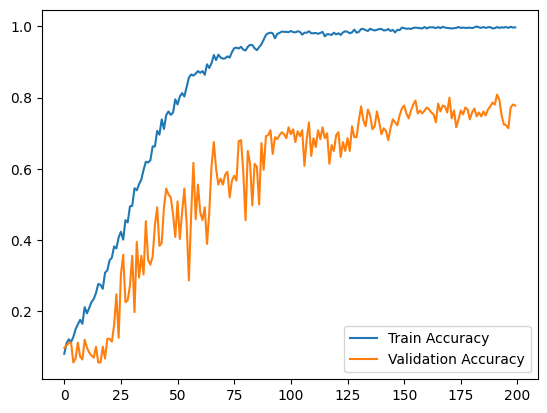

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

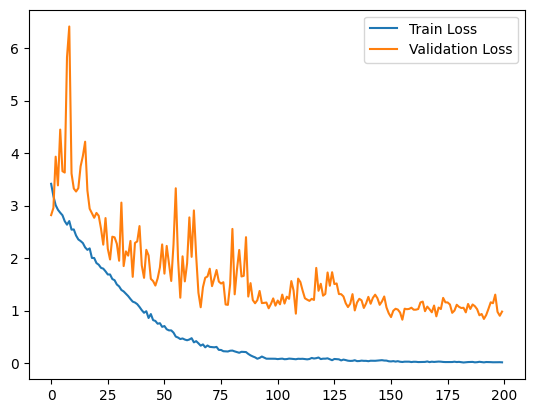

In [11]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import f1_score
import numpy as np

# Obtener las predicciones del modelo
y_pred = modelo_confianza.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtener las etiquetas verdaderas
y_true = test_data.classes

# Calcular el F1-score
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f"F1-score: {f1}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
F1-score: 0.8176750799557817
